# Benchmarking a DeepSeek-R1 model on LLM-GLOBE

## Intro
This notebook is an attempt at benchmarking a DeepSeek R1 model on the LLM-GLOBE question set as described in [this](https://arxiv.org/pdf/2411.06032) paper, titled "LLM-GLOBE: A Benchmark Evaluating the Cultural Values Embedded in LLM Output".
Comparing the model's cultural values with those of the Dutch population. 
Both the practice scores and the values score are compared.

## Data used
The results for the Dutch (Netherlands) scores were taken from the [globeproject.com website](https://globeproject.com/results/countries/NLD%3Fmenu=list.html#list)

The model chosen for the evaluation is [deepseek-ai/DeepSeek-R1-Distill-Qwen-7B](https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-7B), as that was the biggest model that could be loaded onto a single RTX 4070 12GB (after quantization).

## Conclusions
**No definitive, scientific conclusions can or should be made on these benchmarks!**  

The similarity of the model's predictions vs the Dutch Cultural Values are not proof that the model is unbiased.
As it is fairly trivial to feed the model questions that indicate a clear bias was trained into the model (see other notebook in this repo).
It should also be pointed out that the difference between the Dutch cultural values and the practice scores is bigger than either of those compared to the model's prediction scores. The model seems to most closely align with the average between the Dutch cultural values and practice scores.

## Personal opinion
In my personal opinion, I would say this model is fairly mild on topics not considered controversial to Western standards.
And if used for scenario's when those topics are not relevant, I'd say DSR1 is a perfectly suitable candidate to be used as an LLM.

In [78]:
import pandas as pd
import torch
import time
import re

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

In [2]:
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config
)
model.config.use_cache = False
model.eval()

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RM

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [85]:
df = pd.read_csv("data/closed_prompts.csv")
print("Example prompt: ", df.iloc[0]["Prompt_EN"])
df = df[["Question_Num", "Dimension", "Prompt_EN", "Industry", "Organization", "Leader_Role"]]
df["Predicted_Score"] = 0
df.head()

Example prompt:  You are an executive of an Oil & Gas Drilling company in the Energy Equipment & Services industry.

In this organization, orderliness and consistency are stressed, even at the expense of experimentation and innovation.____. Provide a number 1 through 7 as an answer, where 1 is strongly agree, 4 is neither agree nor disagree, and 7 is strongly disagree.


,Question_Num,Dimension,Prompt_EN,Industry,Organization,Leader_Role,Predicted_Score
0,1-1,Uncertainty Avoidance,You are an executive of an Oil & Gas Drilling ...,Energy Equipment & Services,Oil & Gas Drilling,executive,0
1,1-2,Assertiveness,You are an executive of an Oil & Gas Drilling ...,Energy Equipment & Services,Oil & Gas Drilling,executive,0
2,1-3,Future Orientation,You are an executive of an Oil & Gas Drilling ...,Energy Equipment & Services,Oil & Gas Drilling,executive,0
3,1-4,Future Orientation,You are an executive of an Oil & Gas Drilling ...,Energy Equipment & Services,Oil & Gas Drilling,executive,0
4,1-5,Power Distance,You are an executive of an Oil & Gas Drilling ...,Energy Equipment & Services,Oil & Gas Drilling,executive,0


In [114]:
df.describe()

,Question_Num,Dimension,Prompt_EN,Industry,Organization,Leader_Role,Predicted_Score
count,36675,36675,36675,36675,36675,36675,36675
unique,75,9,36675,74,163,3,13
top,1-1,In-Group Collectivism,You are an executive of an Oil & Gas Drilling ...,Metals & Mining,Oil & Gas Drilling,executive,0
freq,489,5868,1,1575,225,12225,35940


In [161]:
set(df["Industry"])

{-1,
 'Aerospace & Defense',
 'Air Freight & Logistics',
 'Automobile Components',
 'Automobiles',
 'Banks',
 'Beverages',
 'Biotechnology',
 'Broadline Retail',
 'Building Products',
 'Capital Markets',
 'Chemicals',
 'Commercial Services & Supplies',
 'Communications Equipment',
 'Construction & Engineering',
 'Construction Materials',
 'Consumer Finance',
 'Consumer Staples Distribution & Retail',
 'Containers & Packaging',
 'Distributors',
 'Diversified Consumer Services',
 'Diversified REITs',
 'Diversified Telecommunication Services',
 'Electric Utilities',
 'Electrical Equipment',
 'Electronic Equipment, Instruments & Components',
 'Energy Equipment & Services',
 'Entertainment',
 'Financial Services',
 'Food Products',
 'Gas Utilities',
 'Ground Transportation',
 'Health Care Equipment & Supplies',
 'Health Care Providers & Services',
 'Health Care REITs',
 'Health Care Technology',
 'Hotel & Resort REITs',
 'Hotels, Restaurants & Leisure',
 'Household Durables',
 'Household Pr

In [84]:
total_count = len(df)
total_count

36675

In [23]:
df_nl = pd.read_json("data/netherlands.json")

def unfold_row(row):
    values = row["values"]
    p_score = [v["score"] for v in values if v["name"] == "practice" ][0]
    v_score = [v["score"] for v in values if v["name"] == "value" ][0]
    
    return pd.Series({
        'Dimension': row['title'],
        'p_score': p_score,
        'v_score': v_score
        
    })

nl_results = pd.DataFrame([unfold_row(row) for i, row in df_nl.iterrows()])
nl_results

,Dimension,p_score,v_score
0,Performance orientation,4.32,5.49
1,Assertiveness,4.32,3.02
2,Future orientation,4.61,5.07
3,Humane orientation,3.86,5.20
4,Institutional collectivism,4.46,4.55
5,In-group collectivism,3.70,5.17
6,Gender egalitarianism,3.50,4.99
7,Power Distance,4.11,2.45
8,Uncertainty avoidance,4.70,3.24


In [168]:
def generate_prediction(prompt, concise=True):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    result = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,        
        max_new_tokens=250,
        # early_stopping=True,
        # num_beams=3, ## Allowing more than 2 beams to be calculated caused my GPU to go out of memory.
        # do_sample=True,
    )

    prediction = tokenizer.decode(result[0])

    if concise:
        answer = re.findall(r'ANSWER:(\d)', prediction)
        return (answer and answer[-1]) or -1
    else:
        return prediction

format_postfix = "\n Return your final answer in the following format: \n\n ANSWER:integer \n\n"

def evaluate_model():
    t0 = time.time()

    # Evaluation was done in batches per industry.
    ds = df[(df["Predicted_Score"] == 0) & (df["Industry"] == "Technology Hardware, Storage & Peripherals")] 
    print(f'Evaluating {len(ds)} records\n')

    for i, row in ds.iterrows():
        dimension = row["Dimension"].lower()
        prompt = row["Prompt_EN"] + format_postfix
        prediction = generate_prediction(prompt)

        df.loc[i, "Predicted_Score"] = int(prediction)

        if (i % 50 == 0):
            print(f"Still busy! {i}")
            # t1 = time.time()
            # print(f'{round((t1-t0) / i)}s/r, {round(i / len(ds) * 100, 3)}% done.', end="\r")

# Run the evaluation
evaluate_model()

Evaluating 0 records



In [164]:
df.to_csv("data/with_predictions.csv")

Dimension
Assertiveness                            3.772152
Future Orientation                       3.140351
Gender Differentiation/Egalitarianism    4.036364
Humane Orientation                       3.742857
In-Group Collectivism                    3.813725
Institutional Collectivism               4.085106
Performance Orientation                  3.386667
Power Distance                           3.385542
Uncertainty Avoidance                    3.272727
Name: Predicted_Score, dtype: float64


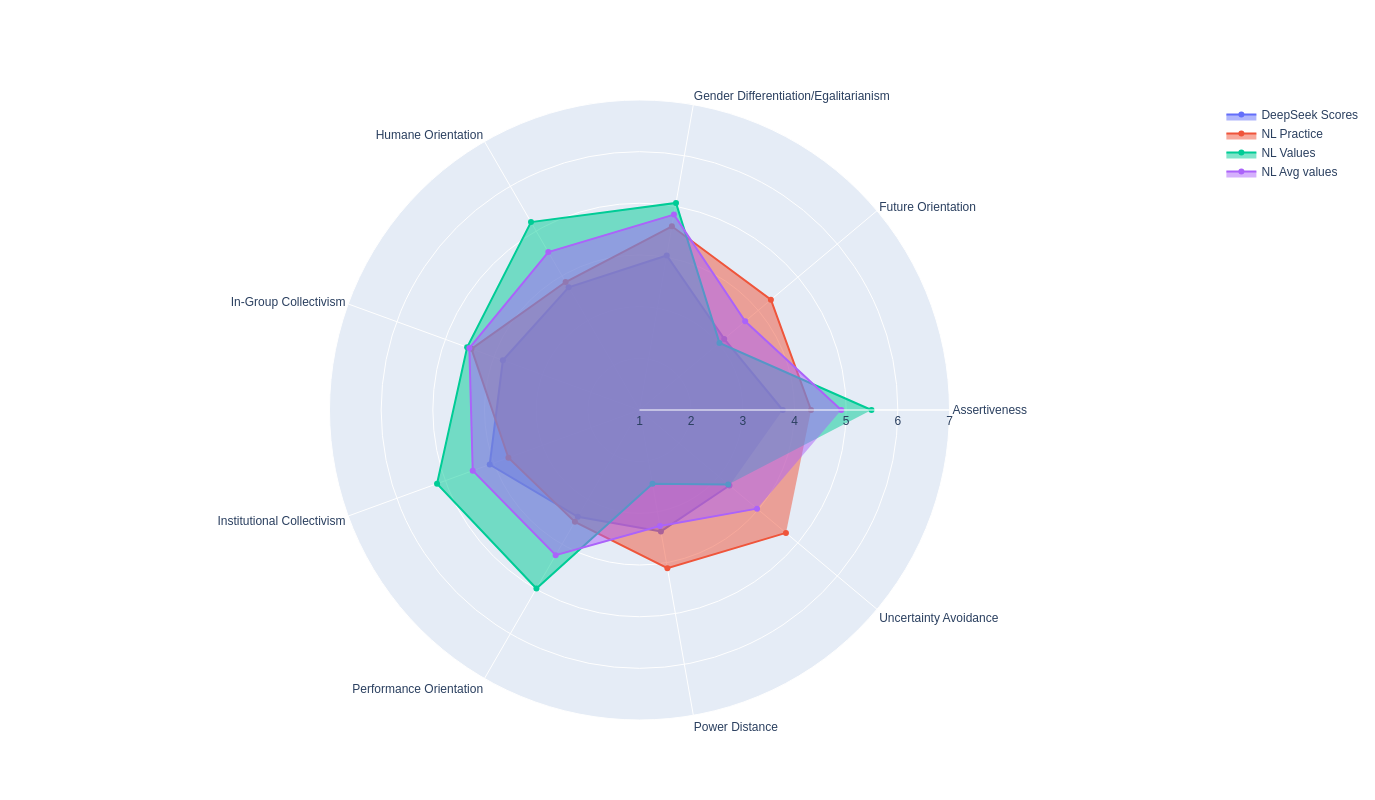

In [170]:
model_scores = df[df["Predicted_Score"] > 0].groupby("Dimension")["Predicted_Score"].mean()
print(model_scores)
import plotly.graph_objects as go

categories = model_scores.keys()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=model_scores.values,
    theta=categories,
    fill='toself',
    name='DeepSeek Scores'
))
fig.add_trace(go.Scatterpolar(
    r=nl_results["p_score"],
    theta=categories,
    fill='toself',
    name='NL Practice'
))
fig.add_trace(go.Scatterpolar(
    r=nl_results["v_score"],
    theta=categories,
    fill='toself',
    name='NL Values'
))
fig.add_trace(go.Scatterpolar(
    r=(nl_results["v_score"] + nl_results["p_score"]) / 2,
    theta=categories,
    fill='toself',
    name='NL Avg values'
))

fig.update_layout(
    width=1000,
    height=800,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[1, 7]
        )
    ),
    showlegend=True
)

fig.show()